# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# SAMSum Dataset Exploration
### Exploratory Data Analysis for Dialogue Summarization
---

This notebook provides comprehensive exploratory data analysis of the SAMSum dataset used throughout the project.

**Goal:**  
Understand the structure, length distributions, and linguistic patterns in the SAMSum dialogue summarization dataset to inform modeling decisions.

**What This Notebook Covers:**
1. Dataset loading and basic statistics
2. Structural features (turns, speakers)
3. Length analysis (characters, words)
4. Compression ratios (dialogue → summary)
5. N-gram distributions (unigrams, bigrams, trigrams)
6. Side-by-side comparisons across **train**, **validation**, and **test** splits

**Note:** All charts and tables can be enabled/disabled via configuration flags.

## 1. Configuration

In [9]:
# =============================================================================
# DISPLAY FLAGS
# =============================================================================
SHOW_CHARTS = True      # Set False when feeding into LLMs
SHOW_TABLES = True      # Set False for minimal output

# =============================================================================
# ANALYSIS PARAMETERS
# =============================================================================
NGRAM_TOP_K = 20        # Number of top n-grams to display
SCATTER_SAMPLE_SIZE = 2000  # Max points in scatter plots

# =============================================================================
# REPRODUCIBILITY
# =============================================================================
SEED = 42

print("Configuration loaded.")
print(f"  Show charts: {SHOW_CHARTS}")
print(f"  Show tables: {SHOW_TABLES}")
print(f"  Random seed: {SEED}")

Configuration loaded.
  Show charts: True
  Show tables: True
  Random seed: 42


## 2. Environment Setup

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from datasets import load_dataset
import warnings
from pathlib import Path
import sys

# Mute common warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Project root for imports
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Set random seeds
np.random.seed(SEED)

# Matplotlib style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

print("Environment ready.")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

Environment ready.
  pandas: 2.3.3
  numpy: 1.26.4


## 3. Load SAMSum Data

In [11]:
from src.data.load_data import load_samsum

# Load the data
train_df, val_df, test_df = load_samsum()

print("="*60)
print("DATASET LOADED")
print("="*60)
print(f"\nDataset sizes:")
print(f"  Train:      {len(train_df):,} examples")
print(f"  Validation: {len(val_df):,} examples")
print(f"  Test:       {len(test_df):,} examples")
print(f"  Total:      {len(train_df) + len(val_df) + len(test_df):,} examples")

DATASET LOADED

Dataset sizes:
  Train:      14,731 examples
  Validation: 818 examples
  Test:       819 examples
  Total:      16,368 examples


In [12]:
# Quick peek at the data
print("\n" + "-"*60)
print("SAMPLE DIALOGUE")
print("-"*60)
print(train_df.iloc[0]["dialogue"])
print("\n" + "-"*60)
print("SAMPLE SUMMARY")
print("-"*60)
print(train_df.iloc[0]["summary"])


------------------------------------------------------------
SAMPLE DIALOGUE
------------------------------------------------------------
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

------------------------------------------------------------
SAMPLE SUMMARY
------------------------------------------------------------
Amanda baked cookies and will bring Jerry some tomorrow.


## 4. Structural Analysis

Analyze the structural features of dialogues:
- Number of turns (utterances) per dialogue
- Number of unique speakers per dialogue

In [13]:
def parse_dialogue_turns(dialogue: str):
    """
    Parse a dialogue string into turns.
    
    Parameters
    ----------
    dialogue : str
        Multi-line dialogue with 'Speaker: utterance' format
    
    Returns
    -------
    list of tuple
        List of (speaker, utterance) pairs
    """
    turns = []
    for line in dialogue.split("\n"):
        line = line.strip()
        if not line:
            continue
        if ":" in line:
            speaker, utt = line.split(":", 1)
            turns.append((speaker.strip(), utt.strip()))
        else:
            turns.append(("UNKNOWN", line))
    return turns


def add_structure_features(df):
    """
    Add structural features to the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'dialogue' column
    
    Returns
    -------
    pd.DataFrame
        Copy with 'n_turns' and 'n_speakers' columns added
    """
    df = df.copy()
    n_turns = []
    n_speakers = []

    for dlg in df["dialogue"]:
        turns = parse_dialogue_turns(dlg)
        speakers = {spk for spk, _ in turns}
        n_turns.append(len(turns))
        n_speakers.append(len(speakers))

    df["n_turns"] = n_turns
    df["n_speakers"] = n_speakers
    return df


print("Structural analysis functions defined.")

Structural analysis functions defined.


## 5. Length Analysis

Analyze length distributions:
- Character and word counts for dialogues
- Character and word counts for summaries
- Data quality checks for empty content

In [14]:
def add_length_features(df, split_name: str = "data"):
    """
    Add length-based features to the dataframe.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'dialogue' and 'summary' columns
    split_name : str
        Name of the split for reporting
    
    Returns
    -------
    pd.DataFrame
        Copy of input with additional columns:
        - dialogue_char_len, summary_char_len
        - dialogue_word_len, summary_word_len
        - summary_fraction (NaN for problematic rows)
    """
    df = df.copy()
    
    # Basic length features
    df["dialogue_char_len"] = df["dialogue"].str.len()
    df["summary_char_len"] = df["summary"].str.len()
    df["dialogue_word_len"] = df["dialogue"].str.split().str.len()
    df["summary_word_len"] = df["summary"].str.split().str.len()
    
    # Calculate summary fraction, handling division by zero
    safe_dialogue_len = df["dialogue_word_len"].replace(0, np.nan)
    safe_summary_len = df["summary_word_len"].replace(0, np.nan)
    df["summary_fraction"] = safe_summary_len / safe_dialogue_len
    
    # Data quality report
    empty_dialogues = (df["dialogue_word_len"] == 0).sum()
    empty_summaries = (df["summary_word_len"] == 0).sum()
    
    print(f"  {split_name.upper()} Data Quality:")
    if empty_dialogues == 0 and empty_summaries == 0:
        print(f"    ✓ No empty dialogues or summaries")
    else:
        if empty_dialogues > 0:
            print(f"    ⚠️  Empty dialogues: {empty_dialogues}")
        if empty_summaries > 0:
            print(f"    ⚠️  Empty summaries: {empty_summaries}")
    
    return df


print("Length analysis functions defined.")

Length analysis functions defined.


In [15]:
print("="*60)
print("COMPUTING FEATURES")
print("="*60)
print()

# Add all features to each split
train = add_length_features(add_structure_features(train_df), "train")
val = add_length_features(add_structure_features(val_df), "validation")
test = add_length_features(add_structure_features(test_df), "test")

print("\nFeatures computed for all splits.")

COMPUTING FEATURES

  TRAIN Data Quality:
    ✓ No empty dialogues or summaries
  VALIDATION Data Quality:
    ✓ No empty dialogues or summaries
  TEST Data Quality:
    ✓ No empty dialogues or summaries

Features computed for all splits.


## 6. Descriptive Statistics

Summary statistics for all computed features across splits.

In [16]:
if SHOW_TABLES:
    print("="*60)
    print("DESCRIPTIVE STATISTICS")
    print("="*60)
    
    for name, df in [("TRAIN", train), ("VALIDATION", val), ("TEST", test)]:
        print(f"\n--- {name} ---")
        display(df.describe())

DESCRIPTIVE STATISTICS

--- TRAIN ---


,n_turns,n_speakers,dialogue_char_len,summary_char_len,dialogue_word_len,summary_word_len,summary_fraction
count,14731.000000,14731.000000,14731.000000,14731.000000,14731.000000,14731.000000,14731.000000
mean,11.167266,2.394610,502.307922,110.139027,93.792750,20.318444,0.295947
std,6.452542,0.828921,397.639839,60.891699,74.031937,11.153570,0.175506
min,3.000000,2.000000,29.000000,3.000000,7.000000,1.000000,0.015385
25%,6.000000,2.000000,212.000000,63.000000,39.000000,12.000000,0.170213
50%,10.000000,2.000000,392.000000,96.000000,73.000000,18.000000,0.256410
75%,15.000000,3.000000,681.000000,144.000000,128.000000,27.000000,0.379310
max,46.000000,14.000000,5474.000000,300.000000,803.000000,64.000000,1.888889



--- VALIDATION ---


,n_turns,n_speakers,dialogue_char_len,summary_char_len,dialogue_word_len,summary_word_len,summary_fraction
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,10.831296,2.387531,490.778729,110.174817,91.641809,20.283619,0.301459
std,6.376279,0.836845,398.527392,61.388822,74.479672,11.211454,0.173940
min,3.000000,2.000000,55.000000,17.000000,10.000000,3.000000,0.019553
25%,6.000000,2.000000,202.500000,63.000000,38.000000,12.000000,0.173115
50%,9.000000,2.000000,378.000000,96.000000,70.000000,18.000000,0.266615
75%,14.000000,3.000000,675.750000,144.000000,127.000000,26.000000,0.387663
max,30.000000,12.000000,2923.000000,300.000000,540.000000,59.000000,1.000000



--- TEST ---


,n_turns,n_speakers,dialogue_char_len,summary_char_len,dialogue_word_len,summary_word_len,summary_fraction
count,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000
mean,11.247863,2.360195,512.457875,108.780220,95.507937,20.017094,0.290010
std,6.352394,0.827952,404.247406,58.461389,75.225291,10.654829,0.173449
min,3.000000,2.000000,47.000000,17.000000,9.000000,3.000000,0.032895
25%,6.000000,2.000000,222.000000,63.000000,42.000000,12.000000,0.162835
50%,10.000000,2.000000,394.000000,96.000000,74.000000,18.000000,0.250000
75%,15.000000,2.000000,674.000000,142.000000,126.000000,26.000000,0.384615
max,30.000000,11.000000,2769.000000,300.000000,516.000000,58.000000,1.222222


In [17]:
if SHOW_TABLES:
    print("\n" + "="*60)
    print("GLOBAL SUMMARY (Train / Val / Test)")
    print("="*60)
    
    metrics = [
        "n_turns",
        "n_speakers",
        "dialogue_word_len",
        "summary_word_len",
        "summary_fraction",
    ]

    combined = pd.DataFrame({
        "train_mean":   train[metrics].mean(),
        "val_mean":     val[metrics].mean(),
        "test_mean":    test[metrics].mean(),
        "train_median": train[metrics].median(),
        "val_median":   val[metrics].median(),
        "test_median":  test[metrics].median(),
    })

    print("\nRows = metrics, Columns = means/medians per split")
    display(combined)


GLOBAL SUMMARY (Train / Val / Test)

Rows = metrics, Columns = means/medians per split


,train_mean,val_mean,test_mean,train_median,val_median,test_median
n_turns,11.167266,10.831296,11.247863,10.00000,9.000000,10.00
n_speakers,2.394610,2.387531,2.360195,2.00000,2.000000,2.00
dialogue_word_len,93.792750,91.641809,95.507937,73.00000,70.000000,74.00
summary_word_len,20.318444,20.283619,20.017094,18.00000,18.000000,18.00
summary_fraction,0.295947,0.301459,0.290010,0.25641,0.266615,0.25


## 7. Structure Visualizations

Charts showing the distribution of turns and speakers across splits.

STRUCTURE DISTRIBUTIONS


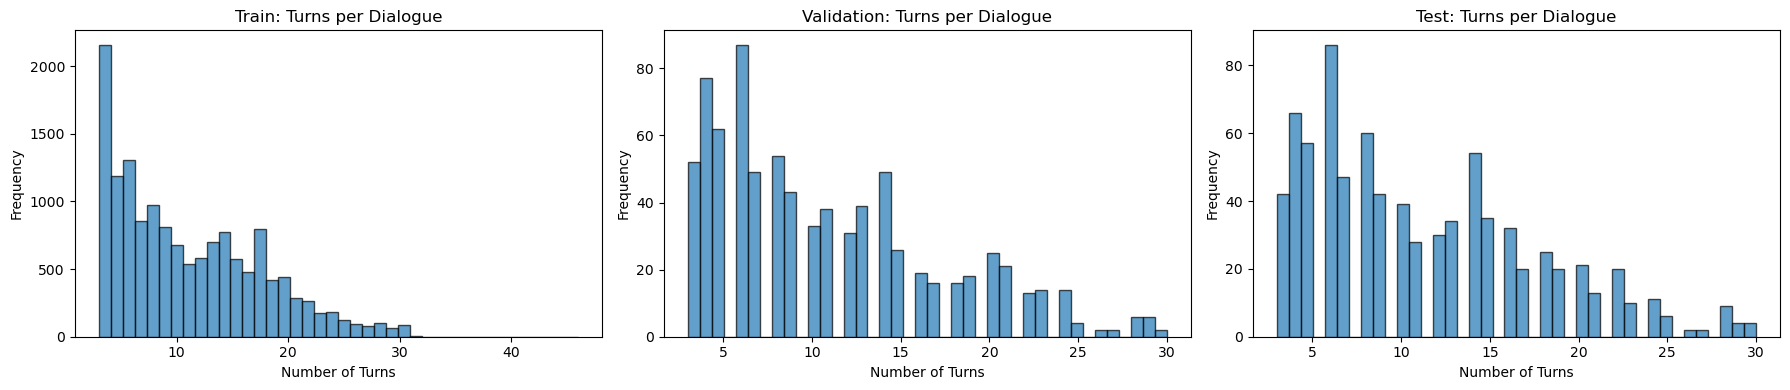

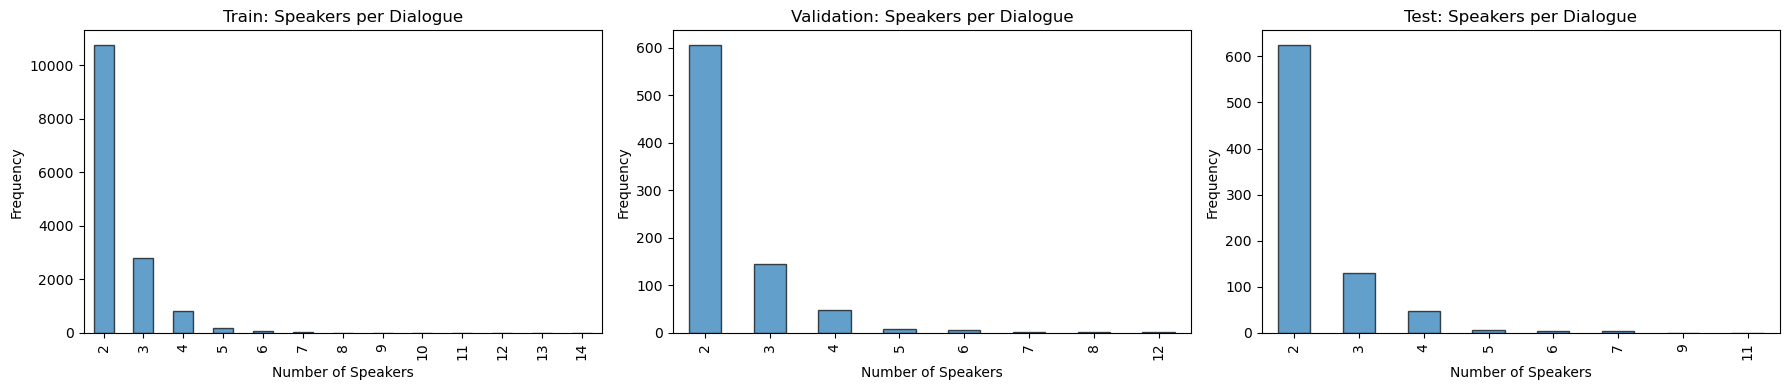

In [18]:
if SHOW_CHARTS:
    print("="*60)
    print("STRUCTURE DISTRIBUTIONS")
    print("="*60)
    
    # Turns per dialogue
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, df, title in zip(axes, [train, val, test], ["Train", "Validation", "Test"]):
        df["n_turns"].plot.hist(ax=ax, bins=40, edgecolor='black', alpha=0.7)
        ax.set_title(f"{title}: Turns per Dialogue")
        ax.set_xlabel("Number of Turns")
        ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Speakers per dialogue
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, df, title in zip(axes, [train, val, test], ["Train", "Validation", "Test"]):
        df["n_speakers"].value_counts().sort_index().plot.bar(ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f"{title}: Speakers per Dialogue")
        ax.set_xlabel("Number of Speakers")
        ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## 8. Length Visualizations

Charts showing dialogue and summary length distributions.

LENGTH DISTRIBUTIONS


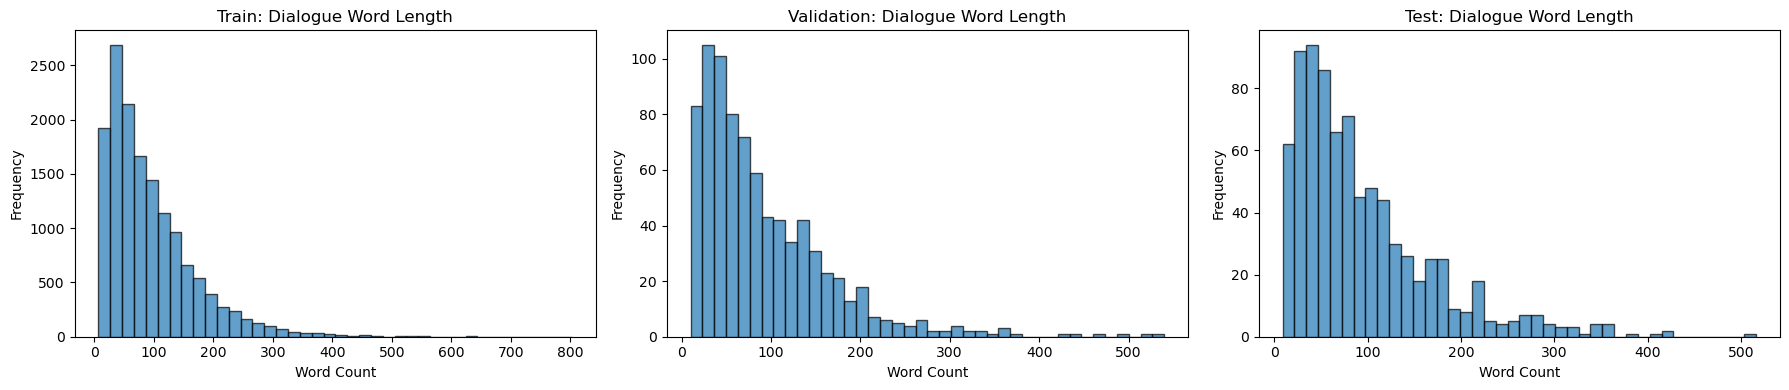

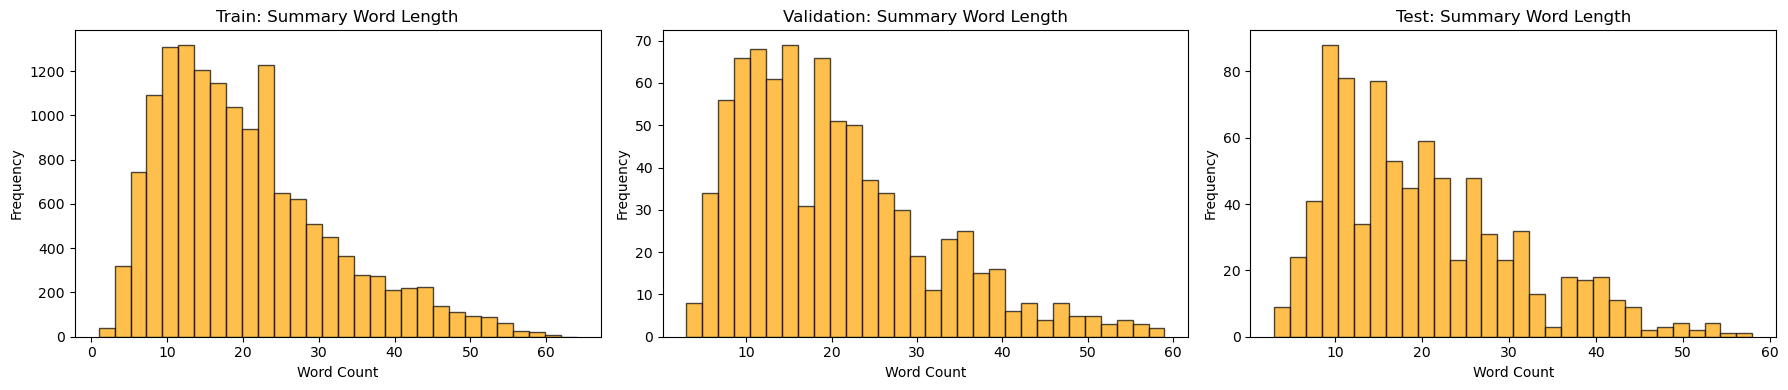

In [19]:
if SHOW_CHARTS:
    print("="*60)
    print("LENGTH DISTRIBUTIONS")
    print("="*60)
    
    # Dialogue word length
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, df, title in zip(axes, [train, val, test], ["Train", "Validation", "Test"]):
        df["dialogue_word_len"].plot.hist(bins=40, ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f"{title}: Dialogue Word Length")
        ax.set_xlabel("Word Count")
        ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Summary word length
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, df, title in zip(axes, [train, val, test], ["Train", "Validation", "Test"]):
        df["summary_word_len"].plot.hist(bins=30, ax=ax, edgecolor='black', alpha=0.7, color='orange')
        ax.set_title(f"{title}: Summary Word Length")
        ax.set_xlabel("Word Count")
        ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## 9. Dialogue vs Summary Length

Scatter plots showing the relationship between dialogue length and summary length.

DIALOGUE vs SUMMARY LENGTH


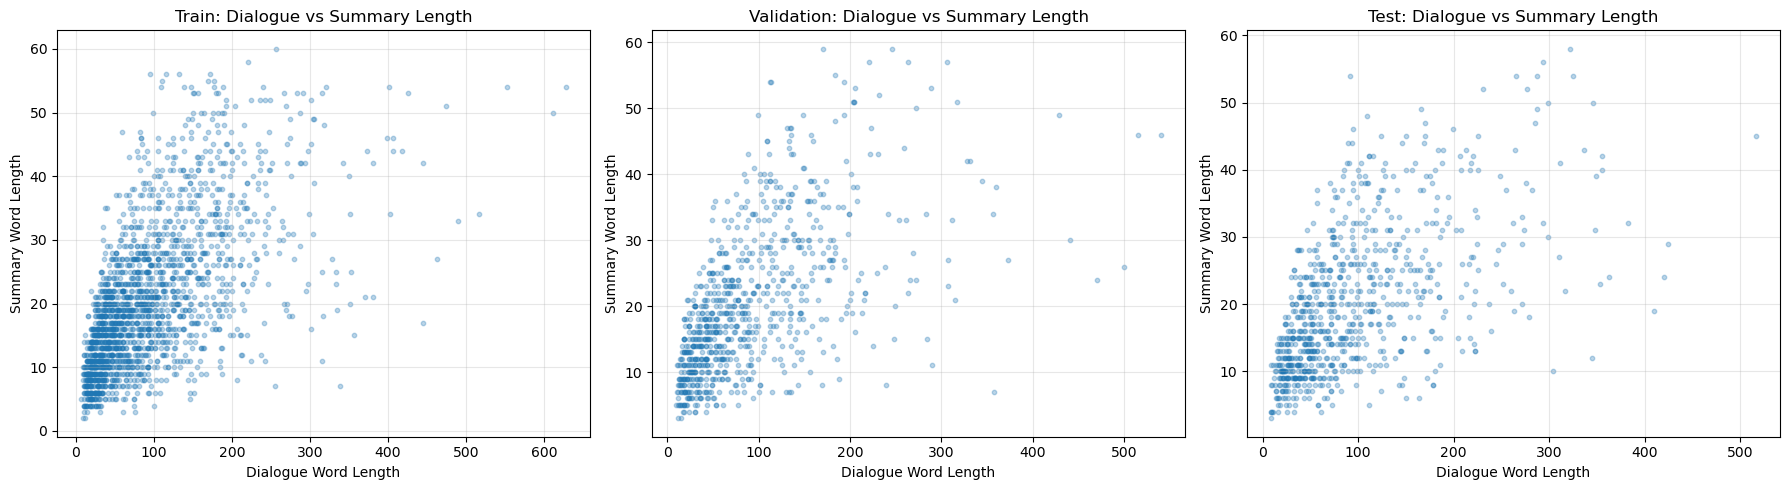

In [20]:
if SHOW_CHARTS:
    print("="*60)
    print("DIALOGUE vs SUMMARY LENGTH")
    print("="*60)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    datasets = [("Train", train), ("Validation", val), ("Test", test)]

    for ax, (name, df) in zip(axes, datasets):
        sample = df.sample(n=min(SCATTER_SAMPLE_SIZE, len(df)), random_state=SEED)
        ax.scatter(
            sample["dialogue_word_len"],
            sample["summary_word_len"],
            alpha=0.3, 
            s=10
        )
        ax.set_title(f"{name}: Dialogue vs Summary Length")
        ax.set_xlabel("Dialogue Word Length")
        ax.set_ylabel("Summary Word Length")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [21]:
if SHOW_TABLES:
    print("\n" + "-"*60)
    print("SAMPLE POINTS (first 100 from each split)")
    print("-"*60)

    for name, df in [("Train", train), ("Validation", val), ("Test", test)]:
        sample = df.sample(n=min(SCATTER_SAMPLE_SIZE, len(df)), random_state=SEED)
        table = sample[["dialogue_word_len", "summary_word_len"]].reset_index(drop=True)
        print(f"\n--- {name.upper()} ---")
        display(table.head(100))


------------------------------------------------------------
SAMPLE POINTS (first 100 from each split)
------------------------------------------------------------

--- TRAIN ---


,dialogue_word_len,summary_word_len
0,37,5
1,474,51
2,92,15
3,21,6
4,299,34
...,...,...
95,38,12
96,139,28
97,45,20
98,47,11



--- VALIDATION ---


,dialogue_word_len,summary_word_len
0,88,21
1,27,12
2,81,20
3,99,17
4,52,12
...,...,...
95,103,28
96,12,3
97,25,13
98,87,20



--- TEST ---


,dialogue_word_len,summary_word_len
0,106,30
1,73,30
2,68,16
3,59,12
4,121,19
...,...,...
95,63,9
96,224,33
97,99,21
98,37,15


## 10. N-gram Analysis

Analysis of the most frequent unigrams, bigrams, and trigrams in dialogues and summaries.

This reveals:
- Common vocabulary in conversational dialogues
- Vocabulary shift in summaries (more formal, third-person)

In [22]:
def top_ngrams(corpus, ngram_range=(1, 1), top_k=20):
    """
    Compute top-k n-grams from a list of texts.
    
    Parameters
    ----------
    corpus : list of str
        Text documents to analyze
    ngram_range : tuple
        (min_n, max_n) for n-gram extraction
    top_k : int
        Number of top n-grams to return
    
    Returns
    -------
    tuple
        (ngrams, counts) as numpy arrays
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    counts = np.asarray(X.sum(axis=0)).ravel()
    
    vocab = np.array(vectorizer.get_feature_names_out())
    top_idx = counts.argsort()[::-1][:top_k]
    
    return vocab[top_idx], counts[top_idx]


def compute_top_ngrams_for_splits(datasets_dict, column="dialogue", ngram_range=(1,1), top_k=20):
    """
    Compute top n-grams for each data split.
    
    Parameters
    ----------
    datasets_dict : dict
        {"train": df, "validation": df, "test": df}
    column : str
        Column to analyze ("dialogue" or "summary")
    ngram_range : tuple
        N-gram range
    top_k : int
        Number of top n-grams
    
    Returns
    -------
    dict
        {split_name: (ngrams, counts)}
    """
    results = {}
    for name, df in datasets_dict.items():
        corpus = df[column].tolist()
        ngrams, counts = top_ngrams(corpus, ngram_range=ngram_range, top_k=top_k)
        results[name] = (ngrams, counts)
    return results


print("N-gram analysis functions defined.")

N-gram analysis functions defined.


In [23]:
def plot_ngram_row(ngram_results, title_prefix):
    """
    Plot horizontal bar charts for n-gram results.
    """
    if not SHOW_CHARTS:
        return

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, (split, (ngrams, counts)) in zip(axes, ngram_results.items()):
        y = np.arange(len(ngrams))
        ax.barh(y, counts, edgecolor='black', alpha=0.7)
        ax.set_yticks(y)
        ax.set_yticklabels(ngrams)
        ax.invert_yaxis()
        ax.set_title(f"{title_prefix} — {split.title()}")
        ax.set_xlabel("Count")
    plt.tight_layout()
    plt.show()


def show_ngram_tables(ngram_results, title_prefix):
    """
    Display tables for n-gram results.
    """
    if not SHOW_TABLES:
        return

    for split, (ngrams, counts) in ngram_results.items():
        print(f"\n--- {title_prefix} — {split.upper()} ---")
        display(pd.DataFrame({"ngram": ngrams, "count": counts}))


print("N-gram visualization functions defined.")

N-gram visualization functions defined.


N-GRAM ANALYSIS

>>> Unigrams (Dialogue)


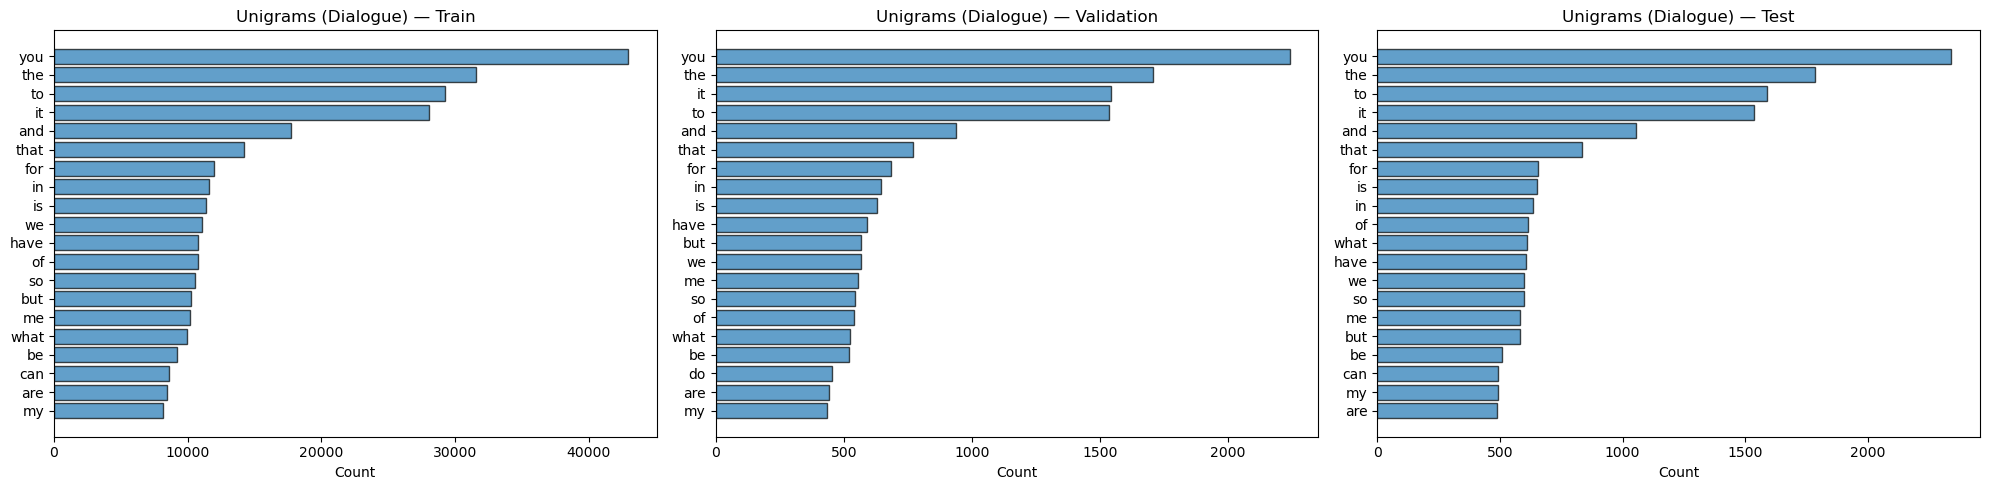


--- Unigrams (Dialogue) — TRAIN ---


,ngram,count
0,you,42926
1,the,31583
2,to,29226
3,it,28066
4,and,17752
5,that,14180
6,for,11989
7,in,11600
8,is,11343
9,we,11077



--- Unigrams (Dialogue) — VALIDATION ---


,ngram,count
0,you,2240
1,the,1708
2,it,1541
3,to,1535
4,and,938
5,that,772
6,for,683
7,in,644
8,is,631
9,have,591



--- Unigrams (Dialogue) — TEST ---


,ngram,count
0,you,2340
1,the,1784
2,to,1587
3,it,1536
4,and,1054
5,that,833
6,for,655
7,is,650
8,in,634
9,of,613



>>> Unigrams (Summary)


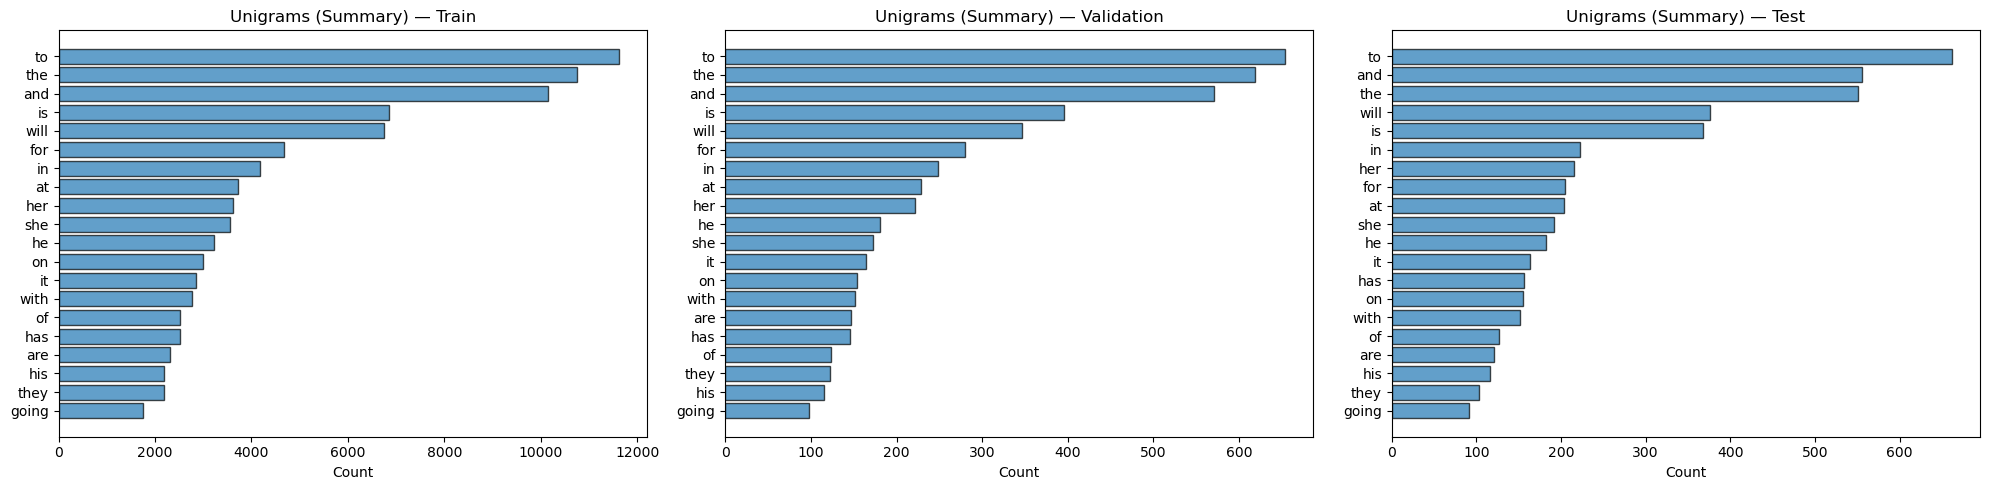


--- Unigrams (Summary) — TRAIN ---


,ngram,count
0,to,11618
1,the,10756
2,and,10146
3,is,6850
4,will,6748
5,for,4678
6,in,4172
7,at,3715
8,her,3609
9,she,3547



--- Unigrams (Summary) — VALIDATION ---


,ngram,count
0,to,654
1,the,618
2,and,571
3,is,395
4,will,346
5,for,280
6,in,249
7,at,229
8,her,222
9,he,181



--- Unigrams (Summary) — TEST ---


,ngram,count
0,to,662
1,and,556
2,the,551
3,will,376
4,is,368
5,in,222
6,her,215
7,for,205
8,at,203
9,she,192


In [24]:
print("="*60)
print("N-GRAM ANALYSIS")
print("="*60)

datasets_dict = {
    "train": train,
    "validation": val,
    "test": test
}

# UNIGRAMS (dialogue)
print("\n>>> Unigrams (Dialogue)")
uni_dialogue = compute_top_ngrams_for_splits(datasets_dict, column="dialogue", ngram_range=(1,1), top_k=NGRAM_TOP_K)
plot_ngram_row(uni_dialogue, "Unigrams (Dialogue)")
show_ngram_tables(uni_dialogue, "Unigrams (Dialogue)")

# UNIGRAMS (summary)
print("\n>>> Unigrams (Summary)")
uni_summary = compute_top_ngrams_for_splits(datasets_dict, column="summary", ngram_range=(1,1), top_k=NGRAM_TOP_K)
plot_ngram_row(uni_summary, "Unigrams (Summary)")
show_ngram_tables(uni_summary, "Unigrams (Summary)")


>>> Bigrams (Dialogue)


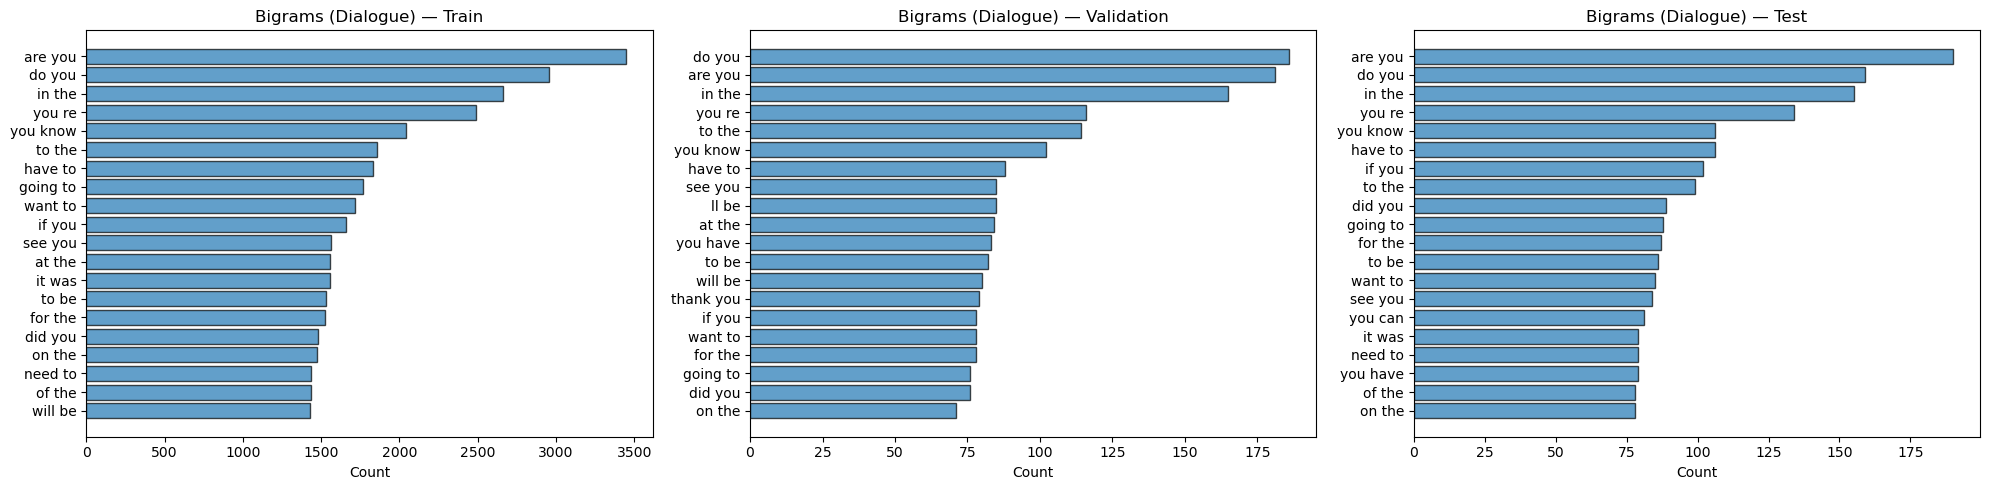


--- Bigrams (Dialogue) — TRAIN ---


,ngram,count
0,are you,3445
1,do you,2957
2,in the,2661
3,you re,2486
4,you know,2040
5,to the,1855
6,have to,1830
7,going to,1769
8,want to,1713
9,if you,1657



--- Bigrams (Dialogue) — VALIDATION ---


,ngram,count
0,do you,186
1,are you,181
2,in the,165
3,you re,116
4,to the,114
5,you know,102
6,have to,88
7,see you,85
8,ll be,85
9,at the,84



--- Bigrams (Dialogue) — TEST ---


,ngram,count
0,are you,190
1,do you,159
2,in the,155
3,you re,134
4,you know,106
5,have to,106
6,if you,102
7,to the,99
8,did you,89
9,going to,88



>>> Bigrams (Summary)


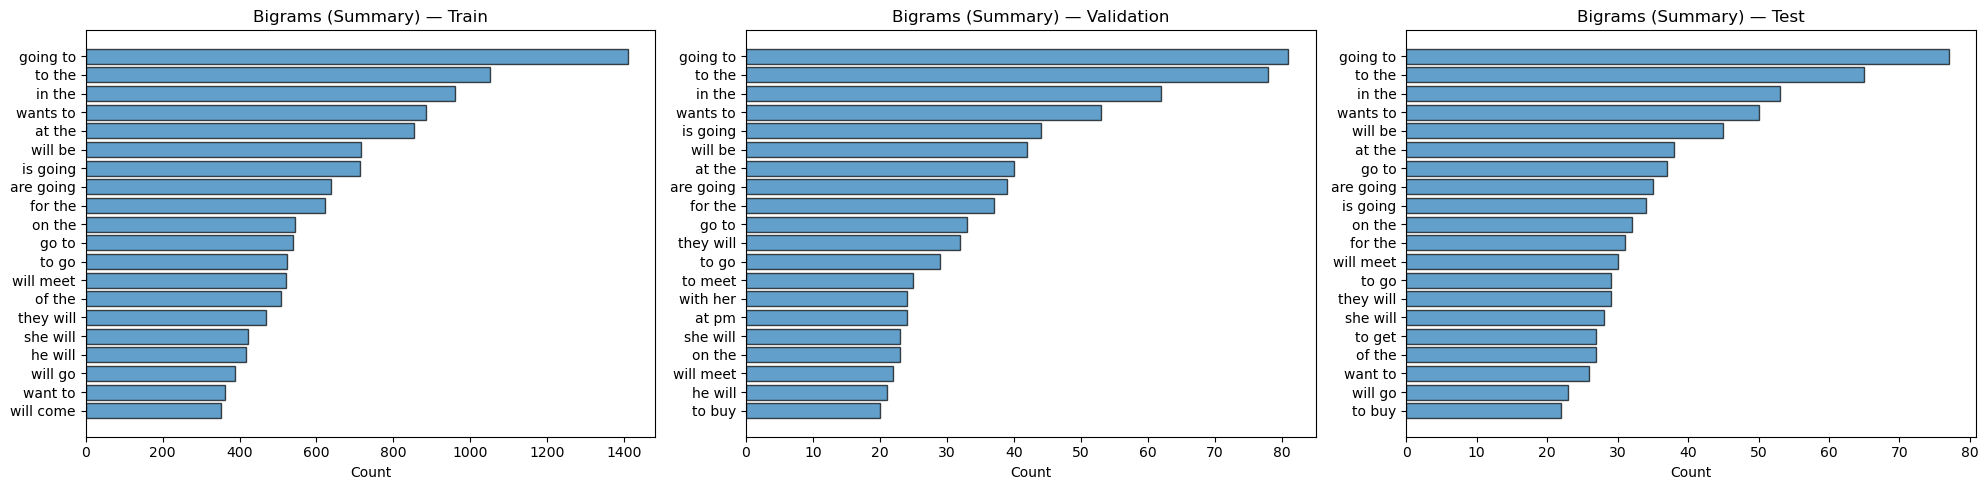


--- Bigrams (Summary) — TRAIN ---


,ngram,count
0,going to,1410
1,to the,1052
2,in the,961
3,wants to,884
4,at the,854
5,will be,716
6,is going,713
7,are going,637
8,for the,621
9,on the,544



--- Bigrams (Summary) — VALIDATION ---


,ngram,count
0,going to,81
1,to the,78
2,in the,62
3,wants to,53
4,is going,44
5,will be,42
6,at the,40
7,are going,39
8,for the,37
9,go to,33



--- Bigrams (Summary) — TEST ---


,ngram,count
0,going to,77
1,to the,65
2,in the,53
3,wants to,50
4,will be,45
5,at the,38
6,go to,37
7,are going,35
8,is going,34
9,on the,32


In [25]:
# BIGRAMS (dialogue)
print("\n>>> Bigrams (Dialogue)")
bi_dialogue = compute_top_ngrams_for_splits(datasets_dict, column="dialogue", ngram_range=(2,2), top_k=NGRAM_TOP_K)
plot_ngram_row(bi_dialogue, "Bigrams (Dialogue)")
show_ngram_tables(bi_dialogue, "Bigrams (Dialogue)")

# BIGRAMS (summary)
print("\n>>> Bigrams (Summary)")
bi_summary = compute_top_ngrams_for_splits(datasets_dict, column="summary", ngram_range=(2,2), top_k=NGRAM_TOP_K)
plot_ngram_row(bi_summary, "Bigrams (Summary)")
show_ngram_tables(bi_summary, "Bigrams (Summary)")


>>> Trigrams (Dialogue)


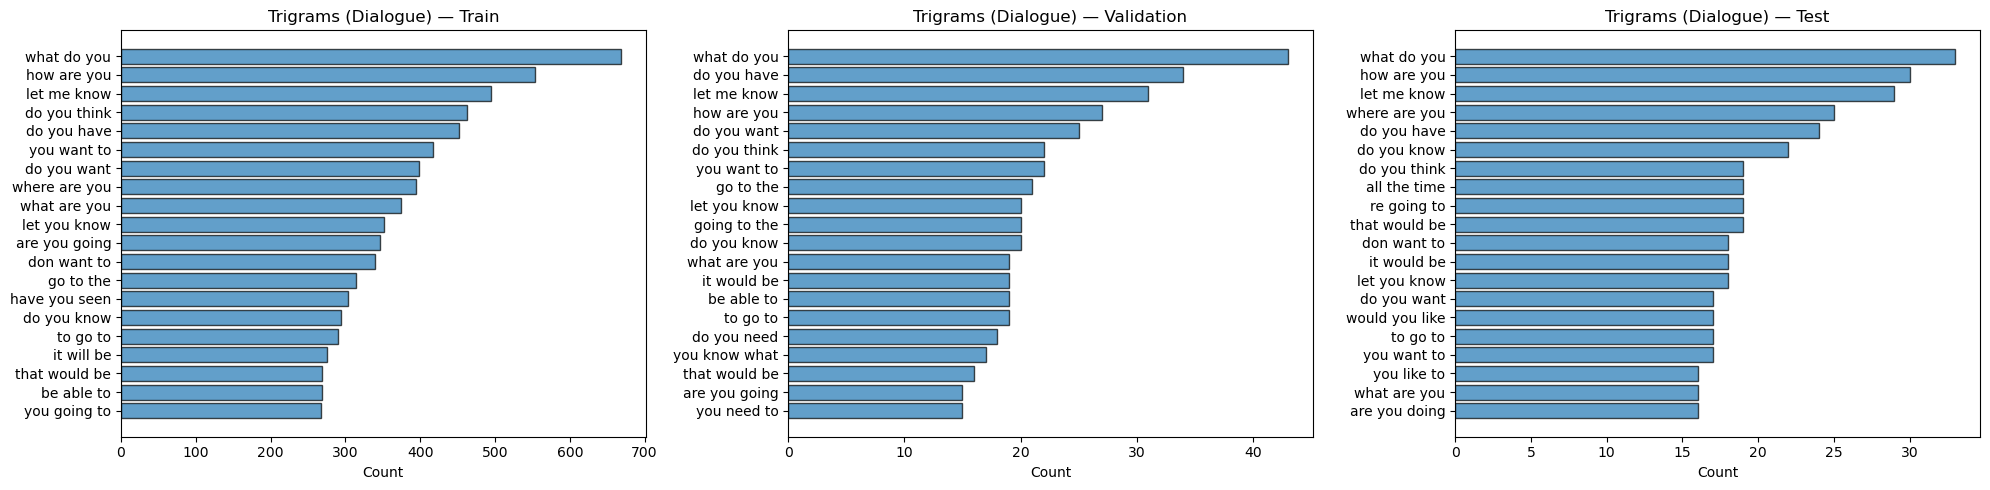


--- Trigrams (Dialogue) — TRAIN ---


,ngram,count
0,what do you,668
1,how are you,553
2,let me know,495
3,do you think,463
4,do you have,452
5,you want to,417
6,do you want,398
7,where are you,394
8,what are you,374
9,let you know,352



--- Trigrams (Dialogue) — VALIDATION ---


,ngram,count
0,what do you,43
1,do you have,34
2,let me know,31
3,how are you,27
4,do you want,25
5,do you think,22
6,you want to,22
7,go to the,21
8,let you know,20
9,going to the,20



--- Trigrams (Dialogue) — TEST ---


,ngram,count
0,what do you,33
1,how are you,30
2,let me know,29
3,where are you,25
4,do you have,24
5,do you know,22
6,do you think,19
7,all the time,19
8,re going to,19
9,that would be,19



>>> Trigrams (Summary)


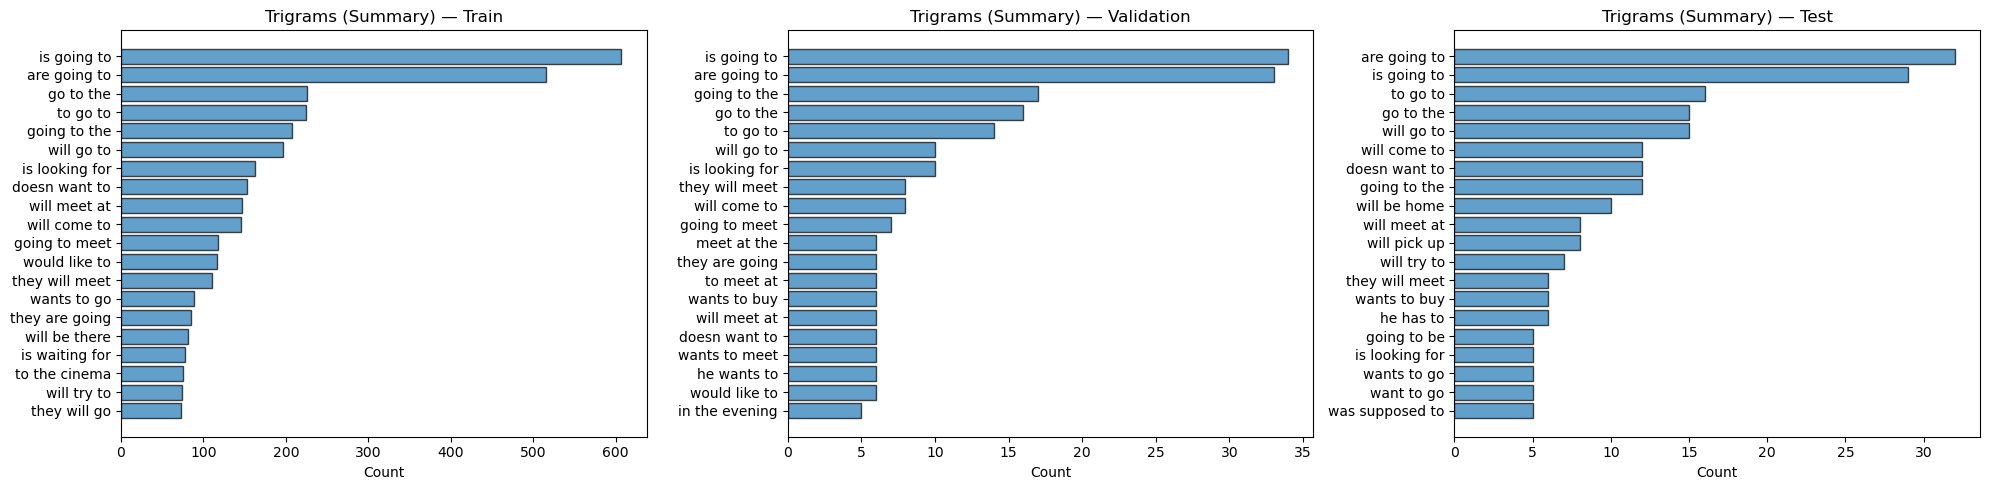


--- Trigrams (Summary) — TRAIN ---


,ngram,count
0,is going to,607
1,are going to,516
2,go to the,226
3,to go to,224
4,going to the,207
5,will go to,196
6,is looking for,163
7,doesn want to,153
8,will meet at,147
9,will come to,146



--- Trigrams (Summary) — VALIDATION ---


,ngram,count
0,is going to,34
1,are going to,33
2,going to the,17
3,go to the,16
4,to go to,14
5,will go to,10
6,is looking for,10
7,they will meet,8
8,will come to,8
9,going to meet,7



--- Trigrams (Summary) — TEST ---


,ngram,count
0,are going to,32
1,is going to,29
2,to go to,16
3,go to the,15
4,will go to,15
5,will come to,12
6,doesn want to,12
7,going to the,12
8,will be home,10
9,will meet at,8


In [26]:
# TRIGRAMS (dialogue)
print("\n>>> Trigrams (Dialogue)")
tri_dialogue = compute_top_ngrams_for_splits(datasets_dict, column="dialogue", ngram_range=(3,3), top_k=NGRAM_TOP_K)
plot_ngram_row(tri_dialogue, "Trigrams (Dialogue)")
show_ngram_tables(tri_dialogue, "Trigrams (Dialogue)")

# TRIGRAMS (summary)
print("\n>>> Trigrams (Summary)")
tri_summary = compute_top_ngrams_for_splits(datasets_dict, column="summary", ngram_range=(3,3), top_k=NGRAM_TOP_K)
plot_ngram_row(tri_summary, "Trigrams (Summary)")
show_ngram_tables(tri_summary, "Trigrams (Summary)")

## 11. Key Takeaways

### Structure is Simple and Consistent

- **Conversations are short:** Train split averages ~11 turns per dialogue, with medians around 9–10.
- **Mostly 2–3 speakers:** Almost all dialogues involve two speakers; three is less common.
- Validation and test splits show **similar distributions**, so no major shift across splits.

**Modeling implication:**  
A standard seq2seq model is appropriate. The dataset does not require special handling for long or highly multi-party conversations.

---

### Lengths and Compression

- **Dialogue length (train):** Mean ~90–95 words, median ~70–75, with a long tail past 500 words.
- **Summary length (train):** Mean ~20 words, median ~18 words.
- **Summary fraction:** Roughly ~0.28–0.30 (summaries are about 28-30% as long as dialogues).

**Modeling implication:**
- The model must compress chats to roughly **one third or less** of their original size.
- A source length around **512 tokens** comfortably covers the long tail.
- A target length around **64–128 tokens** fits the typical summary length.

---

### Dialogue vs Summary Length Relationship

- Longer dialogues correlate with longer summaries, but the relationship saturates.
- Summaries rarely exceed 40–50 words even for very long dialogues.

**Modeling implication:**  
It is reasonable to **cap summary length**, since the task does not reward very long outputs.

---

### N-gram Patterns

- **Dialogues:** Informal, chatty, full of greetings, questions, and first-person pronouns.
- **Summaries:** More abstract, compressed, and action-oriented ("agrees", "decides", "plans"), with a shift toward third-person narration.

**Modeling implication:**  
The model must learn a **style shift**:
- From noisy, multi-speaker, first-person chat  
- To clean, concise, third-person summaries that emphasize decisions and events.

---

### Overall

- The train set shows stable, well-behaved structure for dialogue summarization.  
- Validation/test confirm that the same patterns hold, supporting fair evaluation.
- The task is **real compression** with a clear stylistic transformation.

**Training decisions informed by this analysis:**
- `max_source_length = 512` (covers long tail)
- `max_target_length = 64` (covers typical summaries)
- Beam search kept compact due to short target lengths
- Truncation strategy guided by the long-tail examples